In [1]:
from sys import path
path.insert(0, '..')
import models
import yolo_utils
import platform
import numpy as np
import utillity
import tensorflow as tf
from matplotlib import image
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras import layers, models as md, optimizers
from tensorflow.keras.utils import Sequence
from tqdm import tqdm
from glob import glob
import json

2022-01-07 09:13:33.137850: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-07 09:13:33.137882: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
config = { 
  'image_size' : (416, 416, 3),
  'anchors' : [ 3, 5, 7, 12, 12, 22, 19, 33, 26, 51, 52, 47, 39, 76, 54, 111, 98, 94, 79, 163, 157, 153, 113, 236, 224, 222, 183, 338 ],
  'strides' : [ 16, 32 ],
  'xyscale':[ 0.1, 0.05 ],
  'detector_count' : 2,
  'anchor_size_perdetector': 7,

  # Training
  'iou_loss_thresh': 0.5,
  'batch_size': 32,
  'num_gpu': 1,  # 2,

  # Inference
  'max_boxes': 100,
  'iou_threshold': 0.5,
  'score_threshold': 0.5,
}

In [3]:
weight_path = os.path.join('..', 'assets', 'mobilenet-yolo-light.01-1222.80.h5')
val_notation = os.path.join('..', 'assets', 'validation.txt')
train_notation = os.path.join('..', 'assets', 'training.txt')
predict_path = os.path.join('..', 'assets', 'mnet_yolo', 'predict')
gt_path = os.path.join('..', 'assets', 'mnet_yolo', 'ground_truth')
output_ap = os.path.join('..', 'assets', 'mnet_yolo', 'result')
temp_json = os.path.join('..', 'assets', 'mnet_yolo','temp_json') 
class_name = os.path.join('..', 'assets', 'class_name.txt')
image_path = os.path.join('/home', 'hadioz', 'Documents', 'skripsi', 'dataset', 'WIDER_val', 'images')

In [4]:
with open(val_notation) as file:
  data = json.load(file)

In [5]:
def build_model(config):
  anchors = np.array(config['anchors']).reshape((2, 7, 2))
  inputs = layers.Input(config['image_size'])
  backbone = models.MobileNet(inputs)
  yolo_head = models.FPN_light(backbone, 1, 7)
  basic_model = md.Model(inputs, yolo_head)
  print(anchors[0].shape)
  #basic_model.summary()

  y_input = [layers.Input(shape=(output.shape[1], output.shape[2], 7, (1 + 5))) for output in basic_model.outputs]
  y_input.append(layers.Input(shape=(100, 4)))


  print(y_input)
 
  

  

build_model(config)

2022-01-07 09:13:35.637555: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-07 09:13:35.637632: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ozmonday): /proc/driver/nvidia/version does not exist
2022-01-07 09:13:35.638093: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(7, 2)
[<KerasTensor: shape=(None, 26, 26, 7, 6) dtype=float32 (created by layer 'input_2')>, <KerasTensor: shape=(None, 13, 13, 7, 6) dtype=float32 (created by layer 'input_3')>, <KerasTensor: shape=(None, 100, 4) dtype=float32 (created by layer 'input_4')>]


In [39]:

class DataGenerator(Sequence):
    def __init__(self, label_anotation, image_path, class_name_path, anchors, target_image_shape=(416, 416, 3),
                 batch_size=64, max_boxes=100, shuffle=True, num_stage=3, bbox_per_grid=3):

        self.label_anotation = label_anotation
        self.image_path = image_path
        self.class_name_path = class_name_path
        self.num_stage = num_stage
        self.bboxs_per_grid = bbox_per_grid
        self.num_classes = len([line.strip() for line in open(class_name_path).readlines()])
        self.max_boxes = max_boxes
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.target_image_shape = target_image_shape
        self.indexes = np.arange(len(self.label_anotation))
        self.anchors = np.array(anchors).reshape((num_stage*bbox_per_grid, 2))
        self.on_epoch_end()

    def __len__(self):
        '''number of batches per epoch'''
        return int(np.ceil(len(self.label_anotation) / self.batch_size))

    def __getitem__(self, index):

        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data = [self.label_anotation[i] for i in idxs]
        x, y_tensor, y_bbox = self.__data_generation(data)

        return [x, *y_tensor, y_bbox], np.zeros(len(data))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, label_anotation):
        x = np.empty((len(label_anotation), self.target_image_shape[0], self.target_image_shape[1],
                      self.target_image_shape[2]), dtype=np.float32)
        y_bbox = np.empty((len(label_anotation), self.max_boxes, 5), dtype=np.float32)

        for i, line in enumerate(label_anotation):
            img, boxes = get_data(line, image_path=self.image_path, target_image_shape=self.target_image_shape, max_boxes=self.max_boxes)
            x[i] = img
            y_bbox[i] = boxes

        y_tensor, y_true_boxes_xywh = pre_processing_true_bbox(y_bbox, self.target_image_shape[:2], self.anchors,
                                                             self.num_classes, self.num_stage, self.bboxs_per_grid)

        return x, y_tensor, y_true_boxes_xywh


def get_data(data, image_path, target_image_shape, max_boxes=100):
    if platform.system() == 'Windows':
        name = data['name'].replace("/", "\\")
    else:
        name = data['name']
    filepath = os.path.join(image_path, name)
    img = image.imread(filepath) / 255
    if img.shape != target_image_shape:
        img = tf.image.resize(img, (target_image_shape[0], target_image_shape[1]))
    boxes = np.array([[x['data'][0], x['data'][1], x['data'][2], x['data'][3], 0] for x in data['objects']])
    boxes_data = np.zeros((max_boxes, 5))

    if len(boxes) > 0:
        np.random.shuffle(boxes)
        boxes = boxes[:max_boxes]
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * target_image_shape[0]
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * target_image_shape[1]
        boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

        boxes_data[:len(boxes)] = boxes

    return img, boxes_data


def pre_processing_true_bbox(true_boxes, image_size, anchors, num_classes, num_stage, bbox_per_grid):
    anchor_mask = np.arange(0, num_stage*bbox_per_grid, dtype=int)
    anchor_mask = -np.sort(-anchor_mask).reshape((num_stage, bbox_per_grid))
    anchor_mask = anchor_mask.tolist()

    print(anchor_mask)
    true_boxes = np.array(true_boxes, dtype='float32')
    true_boxes_abs = np.array(true_boxes, dtype='float32')
    image_size = np.array(image_size, dtype='int32')

    true_boxes_xy = (true_boxes_abs[..., 0:2] + true_boxes_abs[..., 2:4]) // 2
    true_boxes_wh = true_boxes_abs[..., 2:4] - true_boxes_abs[..., 0:2]

    true_boxes[..., 0:2] = true_boxes_xy / image_size[::-1]
    true_boxes[..., 2:4] = true_boxes_wh / image_size[::-1]

    bs = true_boxes.shape[0]
    print(bs)
    grid_size = [image_size // [8, 16, 32][-(s+1)] for s in range(num_stage)]
    print(grid_size)
    # grid_size = [image_size // {0: 8, 1: 16, 2: 32}[s] for s in range(num_stage)]
    # Y_true = [np.zeros((bs, grid_size[-(s+1)][0], grid_size[-(s+1)][1], bbox_per_grid, 5 + num_classes), dtype='float32') for s in range(num_stage)]
    Y_true = [np.zeros((bs, grid_size[s][0], grid_size[s][1], bbox_per_grid, 5 + num_classes), dtype='float32') for s in range(num_stage)]
    print(Y_true)
    Y_true_bbox_xywh = np.concatenate((true_boxes_xy, true_boxes_wh), axis=-1)

    anchors = np.expand_dims(anchors, 0)
    anchors_maxs = anchors / 2.
    anchors_mins = -anchors_maxs
    valid_mask = true_boxes_wh[..., 0] > 0

    for batch_index in range(bs):
        wh = true_boxes_wh[batch_index, valid_mask[batch_index]]
        if len(wh) == 0: continue
        wh = np.expand_dims(wh, -2)

        box_maxs = wh / 2.  # (# of bbox, 1, 2)
        box_mins = -box_maxs

        intersect_mins = np.maximum(box_mins, anchors_mins)
        intersect_maxs = np.minimum(box_maxs, anchors_maxs)
        intersect_wh = np.maximum(intersect_maxs - intersect_mins, 0.)
        intersect_area = np.prod(intersect_wh, axis=-1)
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchors = np.argmax(iou, axis=-1)

        for box_index in range(len(wh)):
            best_anchor = best_anchors[box_index]
            for stage in range(num_stage):
                if best_anchor in anchor_mask[stage]:
                    x_offset = true_boxes[batch_index, box_index, 0] * grid_size[stage][1]
                    y_offset = true_boxes[batch_index, box_index, 1] * grid_size[stage][0]

                    grid_col = np.floor(x_offset).astype('int32')
                    grid_row = np.floor(y_offset).astype('int32')
                    anchor_idx = anchor_mask[stage].index(best_anchor)
                    class_idx = true_boxes[batch_index, box_index, 4].astype('int32')
                    print(f'true boxes : {stage} {batch_index} {grid_row} {grid_col} {anchor_idx}')
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, :2] = true_boxes_xy[batch_index,
                                                                                     box_index, :]
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 2:4] = true_boxes_wh[batch_index,
                                                                                      box_index, :]
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 4] = 1

                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 5 + class_idx] = 1

    return reversed(Y_true), Y_true_bbox_xywh



In [43]:
class DataGenerator_old(Sequence):
    def __init__(self, label_anotation, image_path, class_name_path, anchors, target_image_shape=(416, 416, 3),
                 batch_size=64, max_boxes=100, shuffle=True):

        self.label_anotation = label_anotation
        self.image_path = image_path
        self.class_name_path = class_name_path
        self.num_classes = len([line.strip() for line in open(class_name_path).readlines()])
        self.max_boxes = max_boxes
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.target_image_shape = target_image_shape
        self.indexes = np.arange(len(self.label_anotation))
        self.anchors = np.array(anchors).reshape((14, 2))
        self.on_epoch_end()

    def __len__(self):
        '''number of batches per epoch'''
        return int(np.ceil(len(self.label_anotation) / self.batch_size))

    def __getitem__(self, index):

        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        data = [self.label_anotation[i] for i in idxs]
        x, y_tensor, y_bbox = self.__data_generation(data)

        return [x, *y_tensor, y_bbox], np.zeros(len(data))

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, label_anotation):
        x = np.empty((len(label_anotation), 416, 416, 3), dtype=np.float32)
        y_bbox = np.empty((len(label_anotation), 100, 5), dtype=np.float32)

        for i, line in enumerate(label_anotation):
            img, boxes = self.getdata(line)

            x[i] = img
            y_bbox[i] = boxes

        y_tensor, y_true_boxes_xywh = preprocesing_true_bbox(y_bbox, self.target_image_shape[:2], self.anchors,
                                                             self.num_classes)
        return x, y_tensor, y_true_boxes_xywh

    def getdata(self, data):
        if platform.system() == 'Windows':
            name = data['name'].replace("/", "\\")
        else:
            name = data['name']
        filepath = os.path.join(self.image_path, name)
        img = image.imread(filepath) / 255
        if img.shape != (416,416,3):
            img = tf.image.resize(img, (self.target_image_shape[0], self.target_image_shape[1]))

        boxes = np.array([[x['data'][0], x['data'][1], x['data'][2], x['data'][3], 0] for x in data['objects']])
        boxes_data = np.zeros((self.max_boxes, 5))

        if len(boxes) > 0:
            np.random.shuffle(boxes)
            boxes = boxes[:self.max_boxes]
            boxes[:, [0, 2]] = boxes[:, [0, 2]] * self.target_image_shape[0]
            boxes[:, [1, 3]] = boxes[:, [1, 3]] * self.target_image_shape[1]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]

            boxes_data[:len(boxes)] = boxes

        return img, boxes_data


def preprocesing_true_bbox(true_boxes, image_size, anchors, num_classes):
    num_stage = 2
    bbox_per_grid = 7
    anchor_mask = np.arange(0, num_stage*bbox_per_grid, dtype=int)
    anchor_mask = -np.sort(-anchor_mask).reshape((num_stage, bbox_per_grid))
    anchor_mask = anchor_mask.tolist()
    print(anchor_mask)
    true_boxes = np.array(true_boxes, dtype='float32')
    true_boxes_abs = np.array(true_boxes, dtype='float32')
    image_size = np.array(image_size, dtype='int32')

    true_boxes_xy = (true_boxes_abs[..., 0:2] + true_boxes_abs[..., 2:4]) // 2
    true_boxes_wh = true_boxes_abs[..., 2:4] - true_boxes_abs[..., 0:2]

    true_boxes[..., 0:2] = true_boxes_xy / image_size[::-1]
    true_boxes[..., 2:4] = true_boxes_wh / image_size[::-1]

    bs = true_boxes.shape[0]
    grid_size = [image_size // {0: 16, 1: 32}[s] for s in range(num_stage)]
    Y_true = [np.zeros((bs, grid_size[s][0], grid_size[s][1], bbox_per_grid, 5 + num_classes), dtype='float32') for s in
              range(num_stage)]

    Y_true_bbox_xywh = np.concatenate((true_boxes_xy, true_boxes_wh), axis=-1)

    anchors = np.expand_dims(anchors, 0)
    anchors_maxs = anchors / 2.
    anchors_mins = -anchors_maxs
    valid_mask = true_boxes_wh[..., 0] > 0

    for batch_index in range(bs):
        wh = true_boxes_wh[batch_index, valid_mask[batch_index]]
        if len(wh) == 0: continue
        wh = np.expand_dims(wh, -2)

        box_maxs = wh / 2.  # (# of bbox, 1, 2)
        box_mins = -box_maxs

        intersect_mins = np.maximum(box_mins, anchors_mins)
        intersect_maxs = np.minimum(box_maxs, anchors_maxs)
        intersect_wh = np.maximum(intersect_maxs - intersect_mins, 0.)
        intersect_area = np.prod(intersect_wh, axis=-1)
        box_area = wh[..., 0] * wh[..., 1]
        anchor_area = anchors[..., 0] * anchors[..., 1]
        iou = intersect_area / (box_area + anchor_area - intersect_area)

        best_anchors = np.argmax(iou, axis=-1)

        for box_index in range(len(wh)):
            best_anchor = best_anchors[box_index]
            for stage in range(num_stage):
                if best_anchor in anchor_mask[stage]:
                    x_offset = true_boxes[batch_index, box_index, 0] * grid_size[stage][1]
                    y_offset = true_boxes[batch_index, box_index, 1] * grid_size[stage][0]

                    grid_col = np.floor(x_offset).astype('int32')
                    grid_row = np.floor(y_offset).astype('int32')
                    anchor_idx = anchor_mask[stage].index(best_anchor)
                    class_idx = true_boxes[batch_index, box_index, 4].astype('int32')

                    print(f'true boxes : {stage} {batch_index} {grid_row} {grid_col} {anchor_idx}')
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, :2] = true_boxes_xy[batch_index,
                                                                                     box_index, :]
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 2:4] = true_boxes_wh[batch_index,
                                                                                      box_index, :]
                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 4] = 1

                    Y_true[stage][batch_index, grid_row, grid_col, anchor_idx, 5 + class_idx] = 1

    return Y_true, Y_true_bbox_xywh

In [44]:
val_data = DataGenerator_old(data, image_path, class_name, config['anchors'], batch_size=32)

In [45]:
print(val_data.__len__())
data = val_data.__getitem__(5)
sample = data[0][0]
print(data[0][2].shape)

# plt.figure(figsize=(15, 15))
# plt.imshow(sample[0], interpolation='nearest')
# plt.show()

1
(0, 13, 13, 7, 6)


In [8]:
import yolo_light as yl

make_model = yl.Yolo(class_name, config, weight_path)

load from ../assets/mobilenet-yolo-light.01-1222.80.h5
7
7
[<KerasTensor: shape=(None, 26, 26, 7, 4) dtype=float32 (created by layer 'tf.concat_1')>, <KerasTensor: shape=(None, 26, 26, 7, 1) dtype=float32 (created by layer 'tf.math.sigmoid_1')>, <KerasTensor: shape=(None, 26, 26, 7, 1) dtype=float32 (created by layer 'tf.math.sigmoid_2')>, <KerasTensor: shape=(None, 26, 26, 7, 4) dtype=float32 (created by layer 'tf.concat')>, <KerasTensor: shape=(None, 13, 13, 7, 4) dtype=float32 (created by layer 'tf.concat_3')>, <KerasTensor: shape=(None, 13, 13, 7, 1) dtype=float32 (created by layer 'tf.math.sigmoid_4')>, <KerasTensor: shape=(None, 13, 13, 7, 1) dtype=float32 (created by layer 'tf.math.sigmoid_5')>, <KerasTensor: shape=(None, 13, 13, 7, 4) dtype=float32 (created by layer 'tf.concat_2')>]


2022-01-07 09:13:39.812130: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Empty DataFrame
Columns: [x1, y1, x2, y2, score, w, h]
Index: []


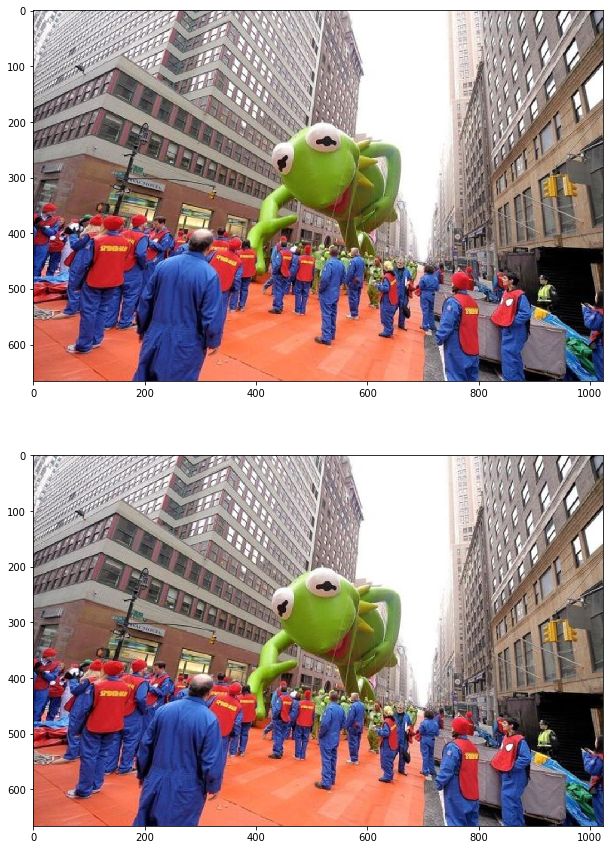

In [9]:
sample = os.path.join(image_path, data[30]['name'])
make_model.predict(sample)